In [8]:
import datetime as dt  		  	   		  		 		  		  		    	 		 		   		 		  
import random  		  	   		  		 		  		  		    	 		 		   		 		  
import matplotlib.pyplot as plt  		  	   		  		 		  		  		    	 		 		   		 		  
import pandas as pd  		  	   		  		 		  		  		    	 		 		   		 		  
from util import get_data, plot_data  		  	   		  		 		  		  		    	 		 		   		 		  
  		  	   		  		 		 
import indicators as ind
import marketsimcode as msc	 


In [479]:
def trades(
    symbol="JPM", 
    sd=dt.datetime(2008, 1, 1), 
    ed=dt.datetime(2009,12,31),
    sv = 100000):
    
    trade = get_data([symbol], pd.date_range(sd, ed)).reset_index().rename(columns={'index': 'Date'})
    del trade['SPY']
    trade['Order'] = None
    trade.loc[0, 'Order'] = "BUY"
    trade['Hold'] = 0 
    trade.loc[0, 'Hold'] = 1000
    trade['Shares'] = 0
    trade.loc[0, 'Shares'] = 1000
    
    syms = [symbol]
    lookback_pd = sd - dt.timedelta(days=50)
    dates = pd.date_range(lookback_pd, ed)
    prices_all = get_data(syms, dates)
    prices = prices_all[syms]
    prices.fillna(method ='ffill',inplace=True)
    prices.fillna(method ='bfill',inplace=True)
    syms_normed = prices/prices.iloc[0]

    trade = pd.merge(trade, syms_normed, on='JPM', how='left')

    
    bbp_vals = ind.calc_bbp(prices)
    ema_vals = ind.calc_ema(prices)
    mom_vals = ind.calc_momentum(prices)
    rsi_vals = ind.calc_rsi(prices)
    macd_vals, sig_vals = ind.calc_macd(prices)
    
    macd_vals.loc[macd_vals['MACD'] > sig_vals['Signal'], 'ind'] = 1
    macd_vals.loc[macd_vals['MACD'] < sig_vals['Signal'], 'ind'] = -1
    
    #print(rsi_vals)
    for i, col in trade[1:].iterrows():
        today_price = col[symbol]
        prev_hold = trade.at[i-1, 'Hold']
        
        if i < len(trade) - 1:
            tmrw_price = trade.iloc[i + 1][symbol]
            bbp = bbp_vals.iloc[i]['BBP']
            ema = ema_vals.iloc[i]['EMA']
            mom = mom_vals.iloc[i]['Momentum']
            rsi = rsi_vals.iloc[i]['RSI']
            macd = macd_vals.iloc[i]['ind']
            
            if mom>=1 or rsi<=30 or bbp<=80:
                if prev_hold == 1000:
                    trade.at[i, 'Order'] = "HOLD"
                    trade.at[i, 'Hold'] = prev_hold
                    trade.at[i, 'Shares'] = 0 
                elif prev_hold == 0: 
                    trade.at[i, 'Order'] = "BUY"
                    trade.at[i, 'Hold'] = prev_hold + 1000
                    trade.at[i, 'Shares'] = 1000 
                elif prev_hold == -1000:
                    trade.at[i, 'Order'] = "BUY"
                    trade.at[i, 'Hold'] = prev_hold + 2000
                    trade.at[i, 'Shares'] = 2000 
                else:
                    pass  
                    
            elif bbp>=20 and rsi>40 and mom<=-0.1:
                if prev_hold <= -1000:
                    trade.at[i, 'Order'] = "HOLD"
                    trade.at[i, 'Hold'] = prev_hold
                    trade.at[i, 'Shares'] = 0 
                elif prev_hold == 0:     
                    trade.at[i, 'Order'] = "SELL"
                    trade.at[i, 'Hold'] = prev_hold - 1000
                    trade.at[i, 'Shares'] = 1000 
                elif prev_hold == 1000:
                    trade.at[i, 'Order'] = "SELL"
                    trade.at[i, 'Hold'] = prev_hold - 2000
                    trade.at[i, 'Shares'] = 2000 
                else:
                    pass
            else:
                trade.at[i, 'Order'] = "HOLD"
                trade.at[i, 'Hold'] = prev_hold
                trade.at[i, 'Shares'] = 0 
    print(trade)
    trades_df = trade.copy()
    del trades_df["JPM"]
    del trades_df["Hold"]
    trades_df['Symbol'] = symbol
    return trades_df

In [480]:
def benchmark_func(symbol="JPM", sd=dt.datetime(2010, 1, 1), ed=dt.datetime(2011,12,31), sv = 100000):
    price = get_data([symbol], pd.date_range(sd, ed)).reset_index().rename(columns={'index': 'Date'})
    del price['SPY']
    price['Order'] = "HOLD"
    price.loc[0, 'Order'] = "BUY"
    price['Shares'] = 0
    price.loc[0, 'Shares'] = 1000
    bm_df = price.copy()
    bm_df["Symbol"] = symbol
    del bm_df[symbol]
    
    return bm_df

In [559]:
bm_df = benchmark_func(symbol = "JPM", sd=dt.datetime(2008, 1, 1), ed=dt.datetime(2009,12,31), sv = 100000) 
jpm = trades(symbol = "JPM", sd=dt.datetime(2008, 1, 1), ed=dt.datetime(2009,12,31), sv = 100000)

buy = jpm[jpm.apply(lambda row: "BUY" in row.values, axis=1)]
sell = jpm[jpm.apply(lambda row: "SELL" in row.values, axis=1)]

display(buy)
display(sell)


          Date    JPM Order  Hold  Shares
0   2008-01-02  38.47   BUY  1000    1000
1   2008-01-03  38.20  HOLD  1000       0
2   2008-01-04  37.33  HOLD  1000       0
3   2008-01-07  37.71  HOLD  1000       0
4   2008-01-08  36.21  HOLD  1000       0
5   2008-01-09  36.72  HOLD  1000       0
6   2008-01-10  37.70  HOLD  1000       0
7   2008-01-11  37.27  HOLD  1000       0
8   2008-01-14  37.73  HOLD  1000       0
9   2008-01-15  35.73  HOLD  1000       0
10  2008-01-16  37.79  HOLD  1000       0
11  2008-01-17  36.52  HOLD  1000       0
12  2008-01-18  36.11  HOLD  1000       0
13  2008-01-22  37.27  HOLD  1000       0
14  2008-01-23  41.70  HOLD  1000       0
15  2008-01-24  41.01  HOLD  1000       0
16  2008-01-25  39.81  HOLD  1000       0
17  2008-01-28  41.57  HOLD  1000       0
18  2008-01-29  43.28  HOLD  1000       0
19  2008-01-30  43.19  HOLD  1000       0
20  2008-01-31  43.24  HOLD  1000       0
21  2008-02-01  44.01  HOLD  1000       0
22  2008-02-04  42.16  HOLD  1000 

,Date,Order,Shares,Symbol
0,2008-01-02,BUY,1000,JPM
220,2008-11-13,BUY,2000,JPM
225,2008-11-20,BUY,2000,JPM
289,2009-02-25,BUY,2000,JPM
371,2009-06-23,BUY,2000,JPM


,Date,Order,Shares,Symbol
219,2008-11-12,SELL,2000,JPM
221,2008-11-14,SELL,2000,JPM
288,2009-02-24,SELL,2000,JPM
370,2009-06-22,SELL,2000,JPM


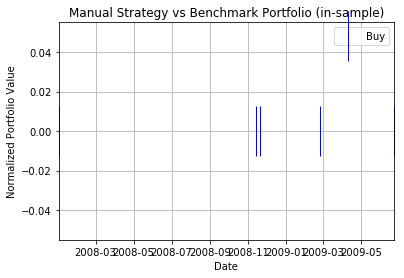

In [540]:
plt.plot(buy['Date'], [0] * len(buy), '|', markersize=50, color='blue', label='Buy')

# Setting up the plot parameters
plt.title("Manual Strategy vs Benchmark Portfolio (in-sample)")
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.grid(True)
plt.margins(x=0)
plt.legend()
plt.show()

### Experiment 1 with trade costs

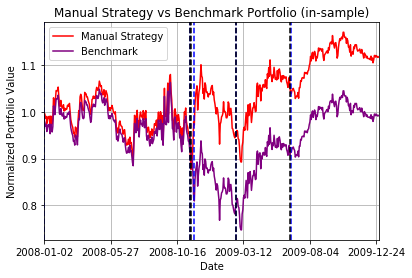

In [557]:
benchmark_1 = msc.compute_portvals(bm_df, start_val=100000, commission=9.95, impact=0.05)
jpm_df_1 = msc.compute_portvals(jpm, start_val=100000, commission=9.95, impact=0.005)
jpm_df_1.rename(columns={'portval': 'Manual Strategy'}, inplace=True)  
benchmark_1.rename(columns={'portval': 'Benchmark'}, inplace=True)
jpm_1 = jpm_df_1.plot(color='red', label='Manual Strategy')
benchmark_1.plot(color='purple', label='Benchmark', ax=jpm_1) 

for i, row in buy.iterrows():
    plt.axvline(x=i, color='blue', linestyle='--', label="Long entry point")
    
for i, row in sell.iterrows():
    plt.axvline(x=i, color='black', linestyle='--', label="Short entry point")
    
plt.title("Manual Strategy vs Benchmark Portfolio (in-sample)")
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.grid(True)
plt.margins(x=0)
plt.show()
#plt.savefig('Manual.png')





In [561]:
bm_df_2 = benchmark_func(symbol = "JPM", sd=dt.datetime(2010, 1, 1), ed=dt.datetime(2011,12,31), sv = 100000) 
jpm_2 = trades(symbol = "JPM", sd=dt.datetime(2010, 1, 1), ed=dt.datetime(2011,12,31), sv = 100000)

buy_2 = jpm_2[jpm_2.apply(lambda row: "BUY" in row.values, axis=1)]
sell_2 = jpm_2[jpm_2.apply(lambda row: "SELL" in row.values, axis=1)]

/Users/yuxi/anaconda3/envs/ml4t/lib/python3.6/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


          Date    JPM Order  Hold  Shares
0   2010-01-04  40.87   BUY  1000    1000
1   2010-01-05  41.67  HOLD  1000       0
2   2010-01-06  41.89  HOLD  1000       0
3   2010-01-07  42.72  HOLD  1000       0
4   2010-01-08  42.62  HOLD  1000       0
5   2010-01-11  42.48  HOLD  1000       0
6   2010-01-12  41.48  HOLD  1000       0
7   2010-01-13  42.21  HOLD  1000       0
8   2010-01-14  42.63  HOLD  1000       0
9   2010-01-15  41.67  HOLD  1000       0
10  2010-01-19  41.28  HOLD  1000       0
11  2010-01-20  41.40  HOLD  1000       0
12  2010-01-21  38.67  HOLD  1000       0
13  2010-01-22  37.35  HOLD  1000       0
14  2010-01-25  37.40  HOLD  1000       0
15  2010-01-26  36.67  HOLD  1000       0
16  2010-01-27  37.52  HOLD  1000       0
17  2010-01-28  37.66  HOLD  1000       0
18  2010-01-29  37.14  HOLD  1000       0
19  2010-02-01  37.80  HOLD  1000       0
20  2010-02-02  38.68  HOLD  1000       0
21  2010-02-03  38.43  HOLD  1000       0
22  2010-02-04  36.58  HOLD  1000 

### out of sample

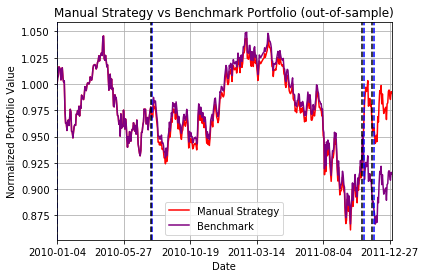

In [562]:
benchmark_2 = msc.compute_portvals(bm_df_2, start_val=100000, commission=9.95, impact=0.005)
jpm_df_2 = msc.compute_portvals(jpm_2, start_val=100000, commission=9.95, impact=0.005)
jpm_df_2.rename(columns={'portval': 'Manual Strategy'}, inplace=True)
benchmark_2.rename(columns={'portval': 'Benchmark'}, inplace=True)

jpm_2 = jpm_df_2.plot(color='red', label='Manual Strategy')
benchmark_2.plot(color='purple', label='Benchmark', ax=jpm_2)

for i, row in buy_2.iterrows():
    plt.axvline(x=i, color='blue', linestyle='--', label="Long entry point")
    
for i, row in sell_2.iterrows():
    plt.axvline(x=i, color='black', linestyle='--', label="Short entry point")
    
plt.title("Manual Strategy vs Benchmark Portfolio (out-of-sample)")
plt.xlabel("Date")
plt.ylabel("Normalized Portfolio Value")
plt.grid(True)
plt.margins(x=0)
plt.show()


In [574]:
def return_vals(port_val):
        dr = ((port_val/port_val.shift(1)) - 1)[1:]
        adr = round(dr.mean(),6)
        cr = round((port_val.iloc[-1]/port_val.iloc[0])-1,6)
        sddr = round(dr.std(), 6)
        df = pd.DataFrame({
            'Cumulative Return': cr,
            'Standard Deviation of Daily Return': sddr,
            'Average Daily Return': adr
        })
        df = df.reset_index(drop=True)
        return df

bench_vals_in = pd.DataFrame(return_vals(benchmark_1))
bench_vals_in['Returns'] = 'Benchmark'
port_vals_in = pd.DataFrame((return_vals(jpm_df_1)))
port_vals_in['Returns'] = 'Portfolio'
combined_df_in = pd.concat([bench_vals_in, port_vals_in])
combined_df_in.set_index('Returns', inplace=True)
    
    
#table of benchmark vs manual out sample
bench_vals_out = pd.DataFrame(return_vals(benchmark_2))
bench_vals_out['Returns'] = 'Benchmark'
port_vals_out = pd.DataFrame((return_vals(jpm_df_2)))
port_vals_out['Returns'] = 'Portfolio'

combined_df_out = pd.concat([bench_vals_out, port_vals_out])
combined_df_out.set_index('Returns', inplace=True)

In [575]:
display(combined_df_in)
display(combined_df_out)

,Cumulative Return,Standard Deviation of Daily Return,Average Daily Return
Returns,,,
Benchmark,0.012543,0.017364,0.000175
Portfolio,0.121036,0.016031,0.000354


,Cumulative Return,Standard Deviation of Daily Return,Average Daily Return
Returns,,,
Benchmark,-0.083579,0.008500,-0.000137
Portfolio,-0.006642,0.008418,0.000022
